[View in Colaboratory](https://colab.research.google.com/github/kireevtf/Resin-treatment-strength-analysis/blob/master/TwoLayerResin.ipynb)

# Function definitions

In [0]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd
import plotly.plotly as py 
from plotly.offline import iplot
import plotly.graph_objs as go
from plotly.graph_objs import Contours, Histogram2dContour, Marker, Scatter

def tostr(number, precision):
    '''
    Converts floating point number to string
    '''
    return ('{0:.' + str(precision) + 'f}').format(number)

def calcPp(rockNu, rockDensity, g, H, R, Rw, p, alpha):
    '''
    Calculates pressure on the outer boundary of the baffle outerlayer, atm
    Arguments:
        rockNu : average Possion's ratio of the overlying rocks, dimensionless
        rockDensity : average density of the overlying rocks, kg/m^3
        g : gravitational acceleration, m/sec^2
        H : the midpoint depth for the considered water shut-off interval, m
        R : external radius of the rock-resin outer layer, m
        Rw : external radius of the inner layer of water baffles (resin layer), m
        p : pressure in the well against the water shut-off zone prior to the WSO treatment, atm
        alpha : Biot’s constant, dimensionless
    '''
    p0 = p
    # rockDensity * g * H = kg/(m*sec^2) = Pa = 1.0/101325 atm
    return ((rockNu) / (1.0 - rockNu)) * rockDensity * g * H * (1.0 - Rw**2/R**2) / 101325 + p0 * Rw**2/R**2 + alpha * p
  
def calcE3nu3(m, E2, nu2, E4, nu4):
    '''
    Calculates E3 and nu3:
        E3 : Young's modulus of the outer rock-resin layer, atm
        nu3 : Possion's ratio of the outer rock-resin layer, dimensionless
    Arguments:
        m : porosity, dimensionless
        E2 : Young's modulus of the inner layer of WSO baffles (resin layer), atm
        E4 : Young's modulus of the rock in the water shut-off interval, atm
        nu2 : Possion's ratio of the inner layer of WSO baffles (resin layer), dimensionless
        nu4 : Possion's ratio of the rock in the water shut-off interval, dimensionless
    '''
    def func(y, m, params):
        '''
        Defines the differential equations for the coupled system
        Arguments:
            w :  vector of the state variables: w = [K3, G3]
            m :  porosity
            p :  vector of the parameters: p = [K2, G2]
        '''
        K3, G3 = y
        K2, G2 = params
        dK3dm = (K2 - K3) * (3*K3 + 4*G3) / ((3*K2 + 4*G3) * (1.0 - m))
        dG3dm = 5*(G2 - G3)*(3*K3 + 4*G3)*G3 / ((4*G3*(3*G2+2*G3) + 3*K3*(2*G2 + 3*G3)) * (1.0 - m))
        return [dK3dm, dG3dm] 
    abserr = 1.0e-10
    relerr = 1.0e-10
    K2 = E2 / (3 * (1.0 - 2*nu2))
    G2 = E2 / (2 * (1.0 + nu2))
    params = [K2, G2]
    f0 = [E4 / (3*(1.0 - 2*nu4)), E4 / (2*(1.0 + nu4))]
    fsol = odeint(func, f0, [0, m], args=(params,), atol=abserr, rtol=relerr)
    K3 = fsol[1][0]
    G3 = fsol[1][1]
    E3 = 9 * K3 * G3 / (3*K3 + G3)
    nu3 = (3*K3 - 2*G3) / (6*K3 + 2*G3)
    return E3, nu3
  
def calcSigmas3(m, sigmas2, sigmas4):
    '''
    Calculates compression strength of resin-rock composite, atm
    Arguments:
        m : porosity, dimensionless
        sigmas2 : compression strength of resin, atm
        sigmas4 : compression strength of the rock of the water shut-off interval, atm     
    '''
    sigmas3 = m * sigmas2 + (1.0 - m) * sigmas4
    return sigmas3
  
def calcPePr(E1, E2, E3, nu1, nu2, nu3, Re, Rw, Rt, R, pw, pp):
    '''
    Calculates Pe and Pr:
        Pe : pressure on the external wall of the production casing (inner wall of the baffle inner layer), atm
        Pr : pressure on the outer boundary of the baffle inner layer (inner boundary of the baffle outer layer), atm
    Arguments:
        E1 : Young's modulus of the production casing, atm
        E2 : Young's modulus of the inner layer of WSO baffles (resin layer), atm
        E3 : Young's modulus of the outer rock-resin layer, atm
        nu1 : Possion's ratio of the production casing, dimensionless
        nu2 : Possion's ratio of the inner layer of WSO baffles (resin layer), dimensionless  
        nu3 : Possion's ratio of the outer rock-resin layer, dimensionless
        Re : external radius of the production casing, m
        Rw : external radius of the inner layer of water baffles (resin layer), m
        Rt : internal radius of the production casing, m
        R : external radius of the rock-resin outer layer, m
        pw : pressure inside the production casing, atm
        pp : pressure on the outer boundary of the baffle outer layer, atm
    '''
    a11 = Re
    a12 = 1.0 / Re
    a13 = -a11
    a14 = -a12
    a21 = E1 / ((1 + nu1) * (1 - 2*nu1))
    a22 = -E1 / ((1 + nu1) * Re**2)
    a23 = -E2 / ((1 + nu2) * (1 - 2*nu2))
    a24 = E2 / ((1 + nu2) * Re**2)
    a33 = Rw
    a34 = 1.0 / Rw
    a35 = -a33
    a36 = -a34
    a43 = -a23
    a44 = -E2 / ((1 + nu2) * Rw**2)
    a45 = -E3 / ((1 + nu3) * (1 - 2*nu3))
    a46 = E3 / ((1 + nu3) * Rw**2)
    a51 = a21
    a52 = -E1 / ((1 + nu1) * Rt**2)
    a65 = -a45
    a66 = -E3 / ((1 + nu3) * R**2)
    A = [[a11, a12, a13, a14, 0, 0],
         [a21, a22, a23, a24, 0, 0],
         [0, 0, a33, a34, a35, a36],
         [0, 0, a43, a44, a45, a46],
         [a51, a52, 0, 0, 0, 0],
         [0, 0, 0, 0, a65, a66]]
    b = [0, 0, 0, 0, -pw, -pp]
    C = np.linalg.solve(A, b)
    A1, B1, A2, B2, A3, B3 = C
    # A1, A2 - dimensionless
    # B1, B2 - m^2
    pe = -E1 * A1 / ((1 + nu1) * (1 - 2*nu1)) + E1 * B1 / ((1 + nu1) * Re**2)
    pr = -E2 * A2 / ((1 + nu2) * (1 - 2*nu2)) + E2 * B2 / ((1 + nu2) * Rw**2)
    return pe, pr
  
def huberMizes(p, P, r0, R, nu, sigmas):
    '''
    Calculates Huber-Mises polynom value
    Arguments:
        p - inner pressure, atm
        P - outer pressure, atm
        r0 - inner radius, m
        R - outer radius, m
        sigmas - compression strength of the material, atm
    '''
    x = p / P
    Sigmas = sigmas / P
    rho = R / r0
    a1 = 3*rho**4 + (1.0 - 2*nu)**2 
    b1 = -2*(3*rho**4 + rho**2 * (1.0 - 2*nu)**2)
    c1 = 4 * (nu**2 - nu + 1.0)*rho**4 - (rho**2 - 1.0)**2 * Sigmas**2
    return a1 * x**2 + b1 * x + c1

def criteria(E1, E2, E4, nu1, nu2, nu4,
             m,
             sigmas2, sigmas4,
             Re, Rw, Rt, R, pw, p,
             rockNu, rockDensity, g, H, alpha):
    '''
    Calculates Mises yield criterion for inner and outer baffle layers
    Arguments:
        E1 : Young's modulus of the production casing, atm
        E2 : Young's modulus of the inner layer of WSO baffles (resin layer), atm
        E4 : Young's modulus of the rock in the water shut-off interval, atm
        nu1 : Possion's ratio of the production casing, dimensionless
        nu2 : Possion's ratio of the inner layer of WSO baffles (resin layer), dimensionless  
        nu4 : Possion's ratio of the rock in the water shut-off interval, dimensionless
        m : porosity, dimensionless
        sigmas2 : compression strength of resin, atm
        sigmas4 : compression strength of the rock of the water shut-off interval, atm     
        Re : external radius of the production casing, m
        Rw : external radius of the inner layer of water baffles (resin layer), m
        Rt : internal radius of the production casing, m
        R : external radius of the rock-resin outer layer, m
        pw : pressure inside the production casing, atm
        p : pressure in the well against the water shut-off zone prior to the WSO treatment, atm
        rockNu : average Possion's ratio of the overlying rocks, dimensionless
        rockDensity : average density of the overlying rocks, kg/m^3
        g : gravitational acceleration, m/sec^2
        H : the midpoint depth for the considered water shut-off interval, m
        alpha : Biot’s constant, dimensionless
    '''
    E3, nu3 = calcE3nu3(m, E2, nu2, E4, nu4)
    sigmas3 = calcSigmas3(m, sigmas2, sigmas4)
    pp = calcPp(rockNu, rockDensity, g, H, R, Rw, p, alpha)
    pe, pr = calcPePr(E1, E2, E3, nu1, nu2, nu3, Re, Rw, Rt, R, pw, pp)
    innerCriteria = huberMizes(pe, pr, Re, Rw, nu2, sigmas2)
    outerCriteria = huberMizes(pr, pp, Rw, R,  nu3, sigmas3)
    return innerCriteria, outerCriteria

def drawParamsTableRus(E1, E2, E4, nu1, R, nu4,
             m, 
             sigmas4, 
             Re, Rw, Rt, p,
             rockNu, rockDensity, g, H, alpha):
    '''
    Displays the parameters in styled table (in russian)
    Arguments:
        E1 : Young's modulus of the production casing, atm
        E2 : Young's modulus of the inner layer of WSO baffles (resin layer), atm
        E4 : Young's modulus of the rock in the water shut-off interval, atm
        nu1 : Possion's ratio of the production casing, dimensionless
        nu4 : Possion's ratio of the rock in the water shut-off interval, dimensionless
        m : porosity, dimensionless
        sigmas4 : compression strength of the rock of the water shut-off interval, atm     
        Re : external radius of the production casing, m
        Rw : external radius of the inner layer of water baffles (resin layer), m
        Rt : internal radius of the production casing, m
        R : external radius of the rock-resin outer layer, m
        p : pressure in the well against the water shut-off zone prior to the WSO treatment, atm
        rockNu : average Possion's ratio of the overlying rocks, dimensionless
        rockDensity : average density of the overlying rocks, kg/m^3
        g : gravitational acceleration, m/sec^2
        H : the midpoint depth for the considered water shut-off interval, m
        alpha : Biot’s constant, dimensionless
    '''
    df = pd.DataFrame({'Параметр': [
            'Внешний радиус скважинной колонны', 
            'Внутренний радиус скважинной колонны',
            'Внешний радиус слоя смолы',
            'Внешний радиус слоя порода+смола',
            'Глубина залегания пласта',
            'Плотность породы',
            'Осредненный коэфф. Пуассона породы',
            'Постоянная Био',
            'Ускорение свободного падения',
            'Пористость пласта',
            'Модуль Юнга скважинной колонны',
            'Модуль Юнга смолы',
            'Модуль Юнга порода+смола',
            'Модуль Юнга породы',
            'Коэфф. Пуассона скважинной колонны',
            'Коэфф. Пуассона смолы',
            'Коэфф. Пуассона порода+смола',
            'Коэфф. Пуассона породы',
            'Прочность слоя смолы',
            'Прочность слоя порода+смола',
            'Прочность породы',
            'Поровое давление',
            'Давление внутри скважинной колонны',
            'Давление на внешней стенке скважинной колонны',
            'Давление на внешней границе слоя смолы',
            'Давление на внешней границе слоя порода+смола (вычислено)',
      ]})
    df = pd.concat([df, 
           pd.DataFrame({'Символьное обозначение': [
            'Re', 
            'Rt',
            'Rw',
            'R',
            'H',
            'rockDensity',
            'rockNu',
            'alpha',
            'g',
            'm',
            'E1',
            'E2',
            'E3',
            'E4',
            'nu1',
            'nu2',
            'nu3',
            'nu4',
            'sigmas2',
            'sigmas3',
            'sigmas4',
            'p',
            'pw',
            'pe',
            'pr',
            'pp'
           ]})], axis=1)
    df = pd.concat([df, 
           pd.DataFrame({'Ед.измерения': [
            'м', 
            'м',
            'м',
            'м',
            'м',
            'кг/м3',
            'д.ед.',
            'д.ед.',
            'м/(сек2)',
            'д.ед.',
            'ГПа',
            'ГПа',
            'ГПа',
            'ГПа',
            'д.ед.',
            'д.ед.',
            'д.ед.',
            'д.ед.',
            'МПа',
            'МПа',
            'МПа',
            'МПа',
            'МПа',
            'МПа',
            'МПа',
            'МПа'
           ]})], axis=1)
    df = pd.concat([df, 
           pd.DataFrame({'Значение': [
            str(Re), 
            str(Rt),
            str(Rw),
            str(R),
            str(H),
            str(rockDensity),
            str(rockNu),
            str(alpha),
            str(g),
            str(m),
            str(E1 * 0.101325 / 1000),
            str(E2 * 0.101325 / 1000),
            'Зависит от nu2',
            str(E4 * 0.101325 / 1000),
            str(nu1),
            'Варьируется',
            'Зависит от nu2',
             str(nu4),
            'Варьируется',
            'Зависит от sigmas2',
             str(sigmas4 * 0.101325),
            str(p * 0.101325),
            'Варьируется',
            'Зависит от pw',
            'Зависит от pw',
            tostr(calcPp(rockNu, rockDensity, g, H, R, Rw, p, alpha) * 0.101325, 1)
           ]})], axis=1)   
    display(df)
    
def drawParamsTable(E1, E2, E4, nu1, R, nu4,
             m, 
             sigmas4, 
             Re, Rw, Rt, p,
             rockNu, rockDensity, g, H, alpha):
    '''
    Displays the parameters in styled table 
    Arguments:
        E1 : Young's modulus of the production casing, atm
        E2 : Young's modulus of the inner layer of WSO baffles (resin layer), atm
        E4 : Young's modulus of the rock in the water shut-off interval, atm
        nu1 : Possion's ratio of the production casing, dimensionless
        nu4 : Possion's ratio of the rock in the water shut-off interval, dimensionless
        m : porosity, dimensionless
        sigmas4 : compression strength of the rock of the water shut-off interval, atm     
        Re : external radius of the production casing, m
        Rw : external radius of the inner layer of water baffles (resin layer), m
        Rt : internal radius of the production casing, m
        R : external radius of the rock-resin outer layer, m
        p : pressure in the well against the water shut-off zone prior to the WSO treatment, atm
        rockNu : average Possion's ratio of the overlying rocks, dimensionless
        rockDensity : average density of the overlying rocks, kg/m^3
        g : gravitational acceleration, m/sec^2
        H : the midpoint depth for the considered water shut-off interval, m
        alpha : Biot’s constant, dimensionless
    '''
    df = pd.DataFrame({'Parameter name': [
            'External radius of the production casing', 
            'Internal radius of the production casing',
            'External radius of the inner layer of water baffles (resin layer)',
            'External radius of the rock-resin outer layer',
            'The midpoint depth for the considered water shut-off interval',
            'Average density of the overlying rocks',
            'Average Possion\'s ratio of the overlying rocks',
            'Biot’s constant',
            'Gravitational acceleration',
            'Porosity',
            'Young\'s modulus of the production casing',
            'Young\'s modulus of the inner layer of WSO baffles (resin layer)',
            'Young\'s modulus of the outer rock-resin layer',
            'Young\'s modulus of the rock in the water shut-off interval',
            'Possion\'s ratio of the production casing',
            'Possion\'s ratio of the inner layer of WSO baffles (resin layer)',
            'Possion\'s ratio of the outer rock-resin layer',
            'Possion\'s ratio of the rock in the water shut-off interval',
            'Compression strength of the inner layer of WSO baffles (resin layer)',
            'Compression strength of the outer rock-resin layer',
            'Compression strength of the rock of the water shut-off interval',
            'Pressure in the well against the water shut-off zone prior to the WSO treatment',
            'Pressure inside the production casing',
            'Pressure on the external wall of the production casing (inner wall of the baffle inner layer)',
            'Pressure on the outer boundary of the baffle inner layer (inner boundary of the baffle outer layer)',
            'Pressure on the outer boundary of the baffle outer layer (calculated)',
      ]})
    df = pd.concat([df, 
           pd.DataFrame({'Designation': [
            'Re', 
            'Rt',
            'Rw',
            'R',
            'H',
            'rockDensity',
            'rockNu',
            'alpha',
            'g',
            'm',
            'E1',
            'E2',
            'E3',
            'E4',
            'nu1',
            'nu2',
            'nu3',
            'nu4',
            'sigmas2',
            'sigmas3',
            'sigmas4',
            'p',
            'pw',
            'pe',
            'pr',
            'pp'
           ]})], axis=1)
    df = pd.concat([df, 
           pd.DataFrame({'Unit of measurement': [
            'm', 
            'm',
            'm',
            'm',
            'm',
            'kg/m^3',
            'dimensionless',
            'dimensionless',
            'm/(sec^2)',
            'dimensionless',
            'GPa',
            'GPa',
            'GPa',
            'GPa',
            'dimensionless',
            'dimensionless',
            'dimensionless',
            'dimensionless',
            'MPa',
            'MPa',
            'MPa',
            'MPa',
            'MPa',
            'MPa',
            'MPa',
            'MPa'
           ]})], axis=1)
    df = pd.concat([df, 
           pd.DataFrame({'Value': [
            str(Re), 
            str(Rt),
            str(Rw),
            str(R),
            str(H),
            str(rockDensity),
            str(rockNu),
            str(alpha),
            str(g),
            str(m),
            str(E1 * 0.101325 / 1000),
            str(E2 * 0.101325 / 1000),
            'Depends on nu2',
            str(E4 * 0.101325 / 1000),
            str(nu1),
            'Varies',
            'Depends on nu2',
             str(nu4),
            'Varies',
            'Depends on sigmas2',
             str(sigmas4 * 0.101325),
            str(p * 0.101325),
            'Varies',
            'Depends on pw',
            'Depends on pw',
            tostr(calcPp(rockNu, rockDensity, g, H, R, Rw, p, alpha) * 0.101325, 1)
           ]})], axis=1)   
    pd.set_option('display.max_colwidth', 1000)
    display(df)
    
def plotNu3InSpaceNu2PwSigmas2(fig, E2, E4, nu1, nu2grid, nu4, m, sigmas2grid, pwgrid, drawGrayscale):  
    '''
    Plots nu3 values in space (nu2, pw, sigmas2)
    Arguments:
        fig - matplotlib pyplot figure
        E2 : Young's modulus of the inner layer of WSO baffles (resin layer), atm
        E4 : Young's modulus of the rock in the water shut-off interval, atm
        nu1 : Possion's ratio of the production casing, dimensionless
        nu2grid : grid for Possion's ratio of the inner layer of WSO baffles (resin layer), dimensionless  
        nu4 : Possion's ratio of the rock in the water shut-off interval, dimensionless
        m : porosity, dimensionless
        sigmas2grid : grid for compression strength of resin, atm
        pwgrid : grid for pressure inside the production casing, atm
        drawGrayscale: use grayscale colors or not, boolean
    '''
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    x, y, z = np.meshgrid(pwgrid, sigmas2grid, nu2grid)
    colors = z.tolist()
    for i, pw in enumerate(pwgrid):
        for j, sigmas2 in enumerate(sigmas2grid):
            for k, nu2 in enumerate(nu2grid):
                E3, nu3 = calcE3nu3(m, E2, nu2, E4, nu4)
                colors[i][j][k] = nu3        
                # Convert atm to MPa
                x[i][j][k] = x[i][j][k] * 0.101325               
                y[i][j][k] = y[i][j][k] * 0.101325 
    cmap = 'gray' if drawGrayscale else 'viridis'
    p2 = ax.scatter(x, y, z, c = np.reshape(colors, (1, x.size))[0], cmap=cmap, s = 150, depthshade = True)
    labelFontSize = 20
    ticklFontSize = 18
    font = {'weight': 'normal', 'size': labelFontSize }
    ax.set_title(r'$\nu_3$', fontsize=labelFontSize)
    ax.set_xlabel(r'$P_w$, MPa', rotation = 0, fontsize=labelFontSize, fontdict=font)
    ax.set_ylabel(r'$\sigma_{s 2}$, MPa', rotation = 0, fontsize=labelFontSize, fontdict=font)
    ax.set_zlabel(r'$\nu_2$', rotation = 90, fontsize=labelFontSize, fontdict=font)
    ax.tick_params(axis='x', which='major', labelsize=ticklFontSize)
    ax.tick_params(axis='y', which='major', labelsize=ticklFontSize)
    ax.tick_params(axis='z', which='major', labelsize=ticklFontSize)   
    ax.zaxis.set_rotate_label(False)
    ax.tick_params(axis="x", pad=-3)
    ax.tick_params(axis="y", pad=-3)
    ax.tick_params(axis="z", pad=-3)
    ax.set_facecolor((1, 1, 1))
    ax.dist = 100
    ax.view_init(elev=20, azim=35)
    cbar = fig.colorbar(p2)
    cbar.ax.tick_params(labelsize=ticklFontSize)
    
def plotE3InSpaceNu2PwSigmas2(fig, E2, E4, nu1, nu2grid, nu4, m, sigmas2grid, pwgrid, drawGrayscale): 
    '''
    Plots E3 values in space (nu2, pw, sigmas2)
    Arguments:
        fig - matplotlib pyplot figure
        E2 : Young's modulus of the inner layer of WSO baffles (resin layer), atm
        E4 : Young's modulus of the rock in the water shut-off interval, atm
        nu1 : Possion's ratio of the production casing, dimensionless
        nu2grid : grid for Possion's ratio of the inner layer of WSO baffles (resin layer), dimensionless  
        nu4 : Possion's ratio of the rock in the water shut-off interval, dimensionless
        m : porosity, dimensionless
        sigmas2grid : grid for compression strength of resin, atm
        pwgrid : grid for pressure inside the production casing, atm
        drawGrayscale: use grayscale colors or not, boolean
    '''
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    x, y, z = np.meshgrid(pwgrid, sigmas2grid, nu2grid)
    colors = z.tolist()
    for i, pw in enumerate(pwgrid):
        for j, sigmas2 in enumerate(sigmas2grid):
            for k, nu2 in enumerate(nu2grid):
                E3, nu3 = calcE3nu3(m, E2, nu2, E4, nu4)
                # Convert atm to GPa
                colors[i][j][k] = E3 * 0.101325 / 1000      
                # Convert atm to MPa
                x[i][j][k] = x[i][j][k] * 0.101325
                y[i][j][k] = y[i][j][k] * 0.101325 
    cmap = 'gray' if drawGrayscale else 'viridis'
    p2 = ax.scatter(x, y, z, c = np.reshape(colors, (1, x.size))[0], cmap=cmap, s = 150, depthshade = True)
    labelFontSize = 20
    ticklFontSize = 18
    font = {'weight': 'normal', 'size': labelFontSize }
    ax.set_title(r'$E_3$, GPa', fontsize=20)
    ax.set_xlabel(r'$P_w$, MPa', rotation = 0, fontsize=labelFontSize, fontdict=font)
    ax.set_ylabel(r'$\sigma_{s 2}$, MPa', rotation = 0, fontsize=labelFontSize, fontdict=font)
    ax.set_zlabel(r'$\nu_2$', rotation = 90, fontsize=labelFontSize, fontdict=font)
    ax.tick_params(axis='x', which='major', labelsize=ticklFontSize)
    ax.tick_params(axis='y', which='major', labelsize=ticklFontSize)
    ax.tick_params(axis='z', which='major', labelsize=ticklFontSize) 
    ax.zaxis.set_rotate_label(False)
    ax.tick_params(axis="x", pad=-3)
    ax.tick_params(axis="y", pad=-3)
    ax.tick_params(axis="z", pad=-3)
    ax.set_facecolor((1, 1, 1))
    ax.dist = 100
    ax.view_init(elev=20, azim=35)
    cbar = fig.colorbar(p2)
    cbar.ax.tick_params(labelsize=ticklFontSize)
    
def plotStaticStrengthInSpaceNu2PwSigmas2(fig, E1, E2, E4, nu1, nu2grid, nu4,
             m,
             sigmas2grid, sigmas4,
             Re, Rw, Rt, R, pwgrid, p,
             rockNu, rockDensity, g, H, alpha, drawGrayscale, baffleLayerIndex):
    '''
    Plots static 3d strength and yield areas of the inner and outer baffle layers in space (nu2, pw, sigmas2)
    The green (gray) color corresponds to the yield areas, the blue (black) color - to the strength areas
    Arguments:
        fig - matplotlib pyplot figure
        E1 : Young's modulus of the production casing, atm
        E2 : Young's modulus of the inner layer of WSO baffles (resin layer), atm
        E4 : Young's modulus of the rock in the water shut-off interval, atm
        nu1 : Possion's ratio of the production casing, dimensionless
        nu2grid : grid for Possion's ratio of the inner layer of WSO baffles (resin layer), dimensionless  
        nu4 : Possion's ratio of the rock in the water shut-off interval, dimensionless
        m : porosity, dimensionless
        sigmas2grid : grid for compression strength of resin, atm
        sigmas4 : compression strength of the rock of the water shut-off interval, atm     
        Re : external radius of the production casing, m
        Rw : external radius of the inner layer of water baffles (resin layer), m
        Rt : internal radius of the production casing, m
        R : external radius of the rock-resin outer layer, m
        pwgrid : grid for pressure inside the production casing, atm
        p : pressure in the well against the water shut-off zone prior to the WSO treatment, atm
        rockNu : average Possion's ratio of the overlying rocks, dimensionless
        rockDensity : average density of the overlying rocks, kg/m^3
        g : gravitational acceleration, m/sec^2
        H : the midpoint depth for the considered water shut-off interval, m
        alpha : Biot’s constant, dimensionless
        drawGrayscale: use grayscale colors or not, boolean
        baffleLayerIndex : 0, 1 or 2 :
            0 - plot strength area of the inner baffle layer
            1 - plot strength area of the outer baffle layer
            2 - plot strength area of the both baffle layers
    '''
    ax = fig.add_subplot(1, 3, baffleLayerIndex + 1, projection='3d')
    x, y, z = np.meshgrid(pwgrid, sigmas2grid, nu2grid)
    colors = z.tolist()
    strengthColor = 'black' if drawGrayscale else 'blue'
    yieldColor = 'grey' if drawGrayscale else 'lime'
    for i, pw in enumerate(pwgrid):
        for j, sigmas2 in enumerate(sigmas2grid):
            for k, nu2 in enumerate(nu2grid):
                critResult = criteria(E1, E2, E4, nu1, nu2, nu4,
                                m,
                                sigmas2, sigmas4,
                                Re, Rw, Rt, R, pw, p,
                                rockNu, rockDensity, g, H, alpha)        
                colors[i][j][k] = yieldColor
                if (baffleLayerIndex == 0):                  
                    if (critResult[0] < 0):
                        colors[i][j][k] = strengthColor
                elif (baffleLayerIndex == 1):
                    if (critResult[1] < 0):
                        colors[i][j][k] = strengthColor
                elif (baffleLayerIndex == 2):
                    if (critResult[0] < 0) and (critResult[1] < 0):
                        colors[i][j][k] = strengthColor                        
                # Convert atm to MPa
                x[i][j][k] = x[i][j][k] * 0.101325 
                y[i][j][k] = y[i][j][k] * 0.101325 
 
    ax.scatter(x, y, z, c = np.reshape(colors, (1, x.size))[0], s = 150, depthshade = True)
    labelFontSize = 18
    ticklFontSize = 16  
    #font = { 'family': 'times new roman', 'weight': 'normal', 'size': labelFontSize }
    font = {'weight': 'normal', 'size': labelFontSize }
    ax.set_xlabel(r'$P_w$, MPa', rotation = 0, fontsize=labelFontSize, fontdict=font)
    ax.set_ylabel(r'$\sigma_{s 2}$, MPa', rotation = 0, fontsize=labelFontSize, fontdict=font)
    ax.set_zlabel(r'$\nu_2$', rotation = 90, fontsize=labelFontSize, fontdict=font)
    ax.tick_params(axis='x', which='major', labelsize=ticklFontSize)
    ax.tick_params(axis='y', which='major', labelsize=ticklFontSize)
    ax.tick_params(axis='z', which='major', labelsize=ticklFontSize)    
    ax.zaxis.set_rotate_label(False)  
    ax.tick_params(axis="x", pad=-3)
    ax.tick_params(axis="y", pad=-3)
    ax.tick_params(axis="z", pad=-3)
    ax.set_facecolor((1, 1, 1))
    if (baffleLayerIndex == 0):
      ax.set_title('Strength of the inner baffle layer', fontsize=labelFontSize)
    elif (baffleLayerIndex == 1):
      ax.set_title('Strength of the outer baffle layer', fontsize=labelFontSize)
    elif (baffleLayerIndex == 2):
      ax.set_title('Strength of both baffle layers', fontsize=labelFontSize)
    ax.dist = 100
    ax.view_init(elev=20, azim=35)
    return x, y, z, colors
  
def plotInteractiveStrengthInSpaceNu2PwSigmas2(x, y, z, colors, title, drawGrayscale):
    '''
    Plots interactive 3d strength and yield areas of the inner and outer baffle layers in space (nu2, pw, sigmas2)
    The green (gray) color corresponds to the yield areas, the blue (black) color - to the strength areas
    Arguments:
        x : x meshgrid from plotStaticStrengthInSpaceNu2PwSigmas2
        y : y meshgrid from plotStaticStrengthInSpaceNu2PwSigmas2
        z : z meshgrid from plotStaticStrengthInSpaceNu2PwSigmas2
        colors : grid coloring from plotStaticStrengthInSpaceNu2PwSigmas2
        title : title for the plot, str
        drawGrayscale: use grayscale colors or not, boolean
    '''
    def enable_plotly_in_cell():
      import IPython
      from plotly.offline import init_notebook_mode
      display(IPython.core.display.HTML('''
            <script src="/static/components/requirejs/require.js"></script>
      '''))
      init_notebook_mode(connected=False)
    enable_plotly_in_cell()   
    strengthColor = 'black' if drawGrayscale else 'blue'
    yieldColor = 'grey' if drawGrayscale else 'lime'
    x_strength, y_strength, z_strength = ([], [], [])
    x_yield, y_yield, z_yield = ([], [], [])
    for i, c1 in enumerate(colors):
      for j, c2 in enumerate(c1):
        for k, c3 in enumerate(c2):
          if (c3 == strengthColor):
            x_strength += [x[i][j][k]]
            y_strength += [y[i][j][k]]
            z_strength += [z[i][j][k]]
          else:
            x_yield += [x[i][j][k]]
            y_yield += [y[i][j][k]]
            z_yield += [z[i][j][k]]             
    trace1 = go.Scatter3d(x=x_strength, y=y_strength, z=z_strength, mode='markers', name = 'Strength area', marker=dict(size=10, color=strengthColor, symbol='circle', opacity=0.7))
    trace2 = go.Scatter3d(x=x_yield, y=y_yield, z=z_yield, mode='markers', name = 'Yield area', marker=dict(size=10, color=yieldColor, symbol='circle', opacity=0.7))  
    layout = go.Layout(
        autosize=False,
        width=600,
        height=600,
        margin=go.Margin(l=50, r=50, b=100, t=100, pad=0),
        title=title,
         scene = dict(
          xaxis=dict(title='Pw, MPa', ticklen=5, zeroline= False, gridwidth=2),
          yaxis=dict(title='sigmas2, MPa', ticklen=5, gridwidth=2),
          zaxis=dict(title='nu2', ticklen= 5,gridwidth=2)
         )
    )
    fig = go.Figure(data=[trace2, trace1], layout=layout)
    iplot(fig)

def plotStrengthYieldAreas(E1, E2, E4, nu1, R, nu4,
             nu2_min, nu2_max,
             m, sigmas2_min, sigmas2_max,
             sigmas4, 
             Re, Rw, Rt, p,
             rockNu, rockDensity, g, H, alpha, 
             drawStaticPlot,
             drawInteractivePlot,
             drawE3nu3,
             drawTable,
             drawGrayscale):
    '''
    Plots static and interactive strength and yield areas of the inner and outer baffle layers in space (nu2, pw, sigmas2)
    Plots E3 and nu3 values in space (nu2, pw, sigmas2)
    Plots parameters in styled table 
    Arguments:
        E1 : Young's modulus of the production casing, atm
        E2 : Young's modulus of the inner layer of WSO baffles (resin layer), atm
        E4 : Young's modulus of the rock in the water shut-off interval, atm
        nu1 : Possion's ratio of the production casing, dimensionless
        nu2_min, nu2_max : min and max for Possion's ratio of the inner layer of WSO baffles (resin layer), dimensionless  
        nu4 : Possion's ratio of the rock in the water shut-off interval, dimensionless
        m : porosity, dimensionless
        sigmas2_min, sigmas2_max : min and max for compression strength of resin, atm
        sigmas4 : compression strength of the rock of the water shut-off interval, atm     
        Re : external radius of the production casing, m
        Rw : external radius of the inner layer of water baffles (resin layer), m
        Rt : internal radius of the production casing, m
        R : external radius of the rock-resin outer layer, m
        p : pressure in the well against the water shut-off zone prior to the WSO treatment, atm
        rockNu : average Possion's ratio of the overlying rocks, dimensionless
        rockDensity : average density of the overlying rocks, kg/m^3
        g : gravitational acceleration, m/sec^2
        H : the midpoint depth for the considered water shut-off interval, m
        alpha : Biot’s constant, dimensionless
        drawStaticPlot : draw static strength and yield areas or not, boolean
        drawInteractivePlot : draw interactive strength and yield areas or not, boolean
        drawE3nu3 : draw E3 and nu3 values or not, boolean
        drawTable : draw parameters table or not, boolean
        drawGrayscale : use grayscale colors or not, boolean
    '''
    gridSize = 10
    pwgrid = np.linspace(0, p, gridSize) 
    nu2grid = np.linspace(nu2_min, nu2_max, gridSize)
    sigmas2grid = np.linspace(sigmas2_min, sigmas2_max , gridSize)  
    if (drawStaticPlot or drawInteractivePlot):
        fig = plt.figure(figsize=(18, 6))
        x1, y1, z1, colors1 = plotStaticStrengthInSpaceNu2PwSigmas2(fig, E1, E2, E4, nu1, nu2grid, nu4,
                             m, sigmas2grid, sigmas4,
                             Re, Rw, Rt, R, pwgrid, p,
                             rockNu, rockDensity, g, H, alpha, drawGrayscale, 0)
        x2, y2, z2, colors2 = plotStaticStrengthInSpaceNu2PwSigmas2(fig, E1, E2, E4, nu1, nu2grid, nu4,
                             m, sigmas2grid, sigmas4,
                             Re, Rw, Rt, R, pwgrid, p,
                             rockNu, rockDensity, g, H, alpha, drawGrayscale, 1)
        x3, y3, z3, colors3 = plotStaticStrengthInSpaceNu2PwSigmas2(fig, E1, E2, E4, nu1, nu2grid, nu4,
                             m, sigmas2grid, sigmas4,
                             Re, Rw, Rt, R, pwgrid, p,
                             rockNu, rockDensity, g, H, alpha, drawGrayscale, 2)
        if (drawStaticPlot):
            plt.show()
        else:
            plt.close(fig)
    
    if (drawE3nu3):
        fig = plt.figure(figsize=(18, 6))
        plotNu3InSpaceNu2PwSigmas2(fig, E2, E4, nu1, nu2grid, nu4, m, sigmas2grid, pwgrid, drawGrayscale)
        plotE3InSpaceNu2PwSigmas2(fig, E2, E4, nu1, nu2grid, nu4, m, sigmas2grid, pwgrid, drawGrayscale)
        plt.show()      
    if (drawInteractivePlot):
        plotInteractiveStrengthInSpaceNu2PwSigmas2(x1, y1, z1, colors1, 'Strength of the inner baffle layer', drawGrayscale)
        plotInteractiveStrengthInSpaceNu2PwSigmas2(x2, y2, z2, colors2, 'Strength of the outer baffle layer', drawGrayscale)
        plotInteractiveStrengthInSpaceNu2PwSigmas2(x3, y3, z3, colors3, 'Strength of both baffle layers', drawGrayscale)
        
    if (drawTable):
        drawParamsTable(E1, E2, E4, nu1, R, nu4,
                 m, sigmas4, 
                 Re, Rw, Rt, p,
                 rockNu, rockDensity, g, H, alpha)

# Strength and yield areas in ($\nu_2, p_w, \sigma_{s2}$)



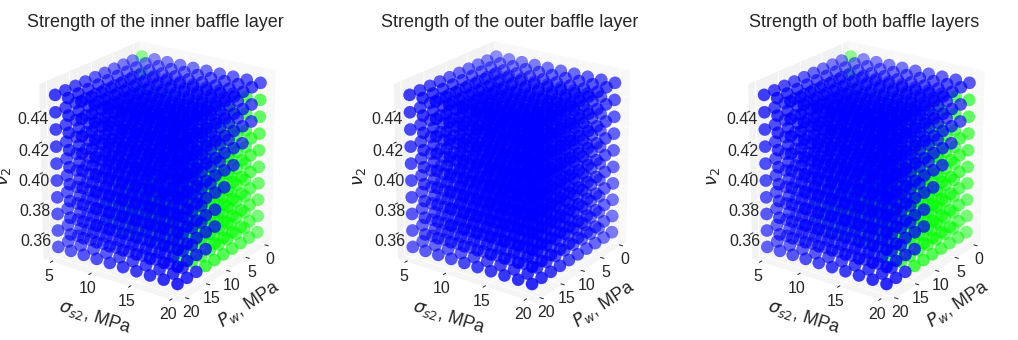

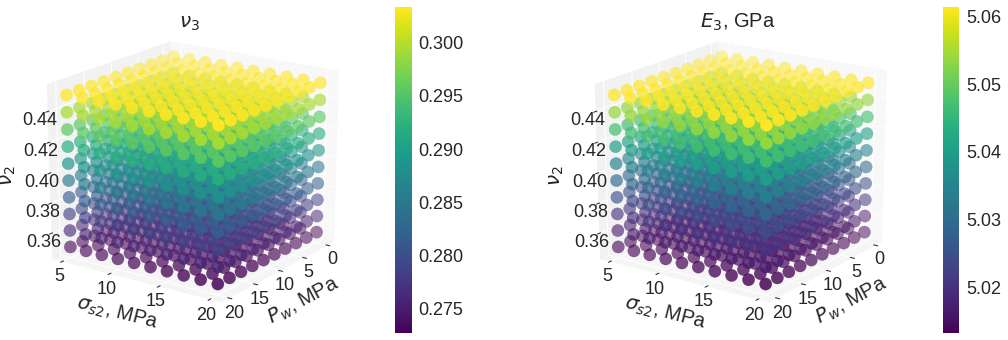

Parameter name  \
0                                                              External radius of the production casing   
1                                                              Internal radius of the production casing   
2                                     External radius of the inner layer of water baffles (resin layer)   
3                                                         External radius of the rock-resin outer layer   
4                                         The midpoint depth for the considered water shut-off interval   
5                                                                Average density of the overlying rocks   
6                                                        Average Possion's ratio of the overlying rocks   
7                                                                                       Biot’s constant   
8                                                                            Gravitational acceleration   
9                                                                                              Porosity   
10                                                             Young's modulus of the production casing   
11                                      Young's modulus of the inner layer of WSO baffles (resin layer)   
12                                                        Young's modulus of the outer rock-resin layer   
13                                           Young's modulus of the rock in the water shut-off interval   
14                                                             Possion's ratio of the production casing   
15                                      Possion's ratio of the inner layer of WSO baffles (resin layer)   
16                                                        Possion's ratio of the outer rock-resin layer   
17                                           Possion's ratio of the rock in the water shut-off interval   
18                                 Compression strength of the inner layer of WSO baffles (resin layer)   
19                                                   Compression strength of the outer rock-resin layer   
20                                      Compression strength of the rock of the water shut-off interval   
21                      Pressure in the well against the water shut-off zone prior to the WSO treatment   
22                                                                Pressure inside the production casing   
23        Pressure on the external wall of the production casing (inner wall of the baffle inner layer)   
24  Pressure on the outer boundary of the baffle inner layer (inner boundary of the baffle outer layer)   
25                                Pressure on the outer boundary of the baffle outer layer (calculated)   

    Designation Unit of measurement               Value  
0            Re                   m               0.073  
1            Rt                   m               0.066  
2            Rw                   m               0.108  
3             R                   m               0.158  
4             H                   m                2000  
5   rockDensity              kg/m^3                2500  
6        rockNu       dimensionless                0.25  
7         alpha       dimensionless                0.85  
8             g           m/(sec^2)             9.80655  
9             m       dimensionless                 0.2  
10           E1                 GPa               204.0  
11           E2                 GPa                 5.0  
12           E3                 GPa      Depends on nu2  
13           E4                 GPa                 5.0  
14          nu1       dimensionless                0.25  
15          nu2       dimensionless              Varies  
16          nu3       dimensionless      Depends on nu2  
17          nu4       dimensionless                0.25  
18      sigmas2                 MPa              Varies  
19      sigmas3                 MPa  De

In [5]:
def main():
    #@markdown ##Plot configuration
    
    # MPa
    sigmas2_min = 5 #@param {type:"number"}
    sigmas2_max = 20 #@param {type:"number"}
    
    # dimensionless
    nu2_min = 0.35 #@param {type:"number"}
    nu2_max = 0.45 #@param {type:"number"}
        
    Draw_static_plots = True #@param {type:"boolean"} 
    Draw_interactive_plots = True #@param {type:"boolean"} 
    Draw_E3_and_nu3 = True #@param {type:"boolean"}
    Draw_parameters_table = True #@param {type:"boolean"}
    Use_grayscale_colors = False #@param {type:"boolean"}
    
    #@markdown ##Model parameters

    # meters
    Re = 0.073 #@param {type:"number"}
    Rw = 0.108 #@param {type:"number"}
    Rt = 0.066 #@param {type:"number"}
    l = 0.05 #@param {type:"slider", min:0.05, max:0.55, step:0.05} 
    R = Rw + l
    
    # kg/m^3
    rock_density = 2500 #@param {type:"number"}
    
    # dimensionless
    rock_nu = 0.25 #@param {type:"number"}
    alpha = 0.85 #@param {type:"number"}
    m = 0.2 #@param {type:"slider", min:0.1, max:0.5, step:0.05} 
    
    # meters/sec^2
    g = 9.80655 #@param {type:"number"}
    
    # meters
    H = 2000 #@param {type:"slider", min:0, max:10000, step:500}  

    # MPa
    E1 = 204000 #@param {type:"number"}  
    E2 = 5000 #@param {type:"slider", min:1000, max:50000, step:1000} 
    E4 = 5000 #@param {type:"slider", min:1000, max:100000, step:1000} 
    
    # dimensionless
    nu1 = 0.25 #@param {type:"number"}
    nu4 = 0.25 #@param {type:"number"}

    # MPa
    sigmas4 = 30 #@param {type:"slider", min:5, max:200, step:5}    
    p = 20 #@param {type:"slider", min:5, max:50, step:5} 
    
    # Plot strength and yield areas
    # Convert MPa to atm
    plotStrengthYieldAreas(E1 / 0.101325, E2 / 0.101325, E4 / 0.101325, nu1, R, nu4,
               nu2_min, nu2_max,
               m, sigmas2_min / 0.101325, sigmas2_max/ 0.101325,
               sigmas4 / 0.101325,
               Re, Rw, Rt, p / 0.101325,
               rock_nu, rock_density, g, H, alpha, 
               Draw_static_plots, 
               Draw_interactive_plots,
               Draw_E3_and_nu3,
               Draw_parameters_table,
               Use_grayscale_colors)
main()